In [1]:
from ultralytics import YOLO

from pathlib import Path
import torch
from torch import nn
import torch.onnx
import torchvision.transforms as transforms

from PIL import Image

# 01 - Load model and make predictions

In [2]:
# Load the model
path_to_model = 'C:/Users/thoma/Documents/GitHub/WING_YOLO/models/yolo11m_250imgs_100epochs/weights/best.pt'
model = YOLO(path_to_model)
model.info()

YOLO11m-seg summary: 253 layers, 22,360,758 parameters, 0 gradients, 123.6 GFLOPs


(253, 22360758, 0, 123.58435839999999)

In [4]:
# Find all images in the directory
test_images = list(Path('raw_images_640x640').glob('*.jpg'))
test_images

[WindowsPath('raw_images_640x640/1240700_5879970.jpg'),
 WindowsPath('raw_images_640x640/1240700_5880098.jpg'),
 WindowsPath('raw_images_640x640/1240828_5879970.jpg'),
 WindowsPath('raw_images_640x640/1240828_5880098.jpg')]

https://docs.ultralytics.com/modes/predict/#inference-arguments

In [5]:
# Make predictions on a test image with YOLO
results = model(
    source=test_images,
    verbose=True)


0: 640x640 9 Roofs, 2 Solars, 277.8ms
1: 640x640 10 Roofs, 277.8ms
2: 640x640 6 Roofs, 277.8ms
3: 640x640 12 Roofs, 6 Solars, 277.8ms
Speed: 2.0ms preprocess, 277.8ms inference, 6.8ms postprocess per image at shape (1, 3, 640, 640)


https://docs.ultralytics.com/reference/engine/results/#ultralytics.engine.results.Results.show

In [7]:
# Display the results
for pred in results:
    pred.show(
        boxes=False,
    )

In [34]:
# ...existing code...

output_dir = Path('combined_masks')
output_dir.mkdir(exist_ok=True)

for i, (pred, img_path) in enumerate(zip(results, test_images)):
    if pred.masks is not None:
        masks = pred.masks.data  # shape: (num_instances, H, W)
        combined_mask = (masks.sum(dim=0) > 0).byte()
        mask_img = Image.fromarray((combined_mask.cpu().numpy() * 255).astype('uint8'))
        # Use original image name, change extension to .png
        mask_name = Path(img_path).stem + '.jpg'
        mask_img.save(output_dir / mask_name)
# ...existing code...

In [15]:
results[0].masks[0]

ultralytics.engine.results.Masks object with attributes:

data: tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
orig_shape: (640, 640)
shape: torch.Size([1, 640, 640])
xy: [array([[        276,         210],
       [        276,         213],
       [        275,         214],
       [        274,         214],
       [        273,         215],
       [        272,         215],
       [        271,         216],
       [        269,         216],
       [        268,         217],
       [        266,         217],
       [        265,         218],
       [        263,         218],
       [        262,         219],
       [        260,         219],
       [        259,         220],
       [        257,         220],
       [        256,         221],
       [        25

# 02 - Extract segmentation masks

Export ONXX for Deepness  
https://qgis-plugin-deepness.readthedocs.io/en/latest/

In [11]:
masks = results[1].masks  # ultralytics.engine.results.Masks object
classes = results[1].boxes.cls.int()  # Tensor of class indices for each mask
num_classes = int(classes.max().item()) + 1  # Or set manually if known

# masks.data: (num_instances, H, W)
mask_data = masks.data  # shape: (num_instances, H, W)
H, W = mask_data.shape[1:]

# Create one-hot tensor: (num_classes, H, W)
onehot = torch.zeros((num_classes, H, W), dtype=torch.uint8)

for idx, class_idx in enumerate(classes):
    onehot[class_idx] |= (mask_data[idx] > 0).byte()

In [8]:
onehot.shape

torch.Size([1, 640, 640])

In [10]:
# save the one-hot encoded masks as tiff files
output_dir = Path('onehot_masks')
output_dir.mkdir(exist_ok=True)
for i, mask in enumerate(onehot):
    class_name = f'class_{i}'
    output_path = output_dir / f'{class_name}.tiff'
    transforms.ToPILImage()(mask).save(output_path, format='TIFF')
    print(f'Saved {output_path}')

Saved onehot_masks\class_0.tiff


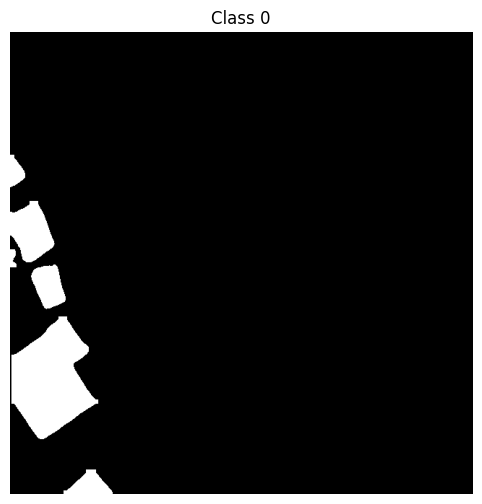

In [9]:
# plot the one-hot encoded masks
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for i in range(num_classes):
    plt.subplot(1, num_classes, i + 1)
    plt.imshow(onehot[i].cpu().numpy(), cmap='gray')
    plt.title(f'Class {i}')
    plt.axis('off')

In [ ]:
results[0].masks

## Extract model to PyTorch

In [ ]:
# Load the image
image = Image.open('test_image.png').convert('RGB')

# Transorm image to tensor
image_to_tensor = transforms.ToTensor()
image_tensor = image_to_tensor(image).unsqueeze(0)  # add batch dimension

print(f'Shape: {image_tensor.shape}')
print(f'Values (min/max): {image_tensor.min(), image_tensor.max()}')

In [ ]:
# Extract the pytorch model
pytorch_model = model.model

In [ ]:
# Make predictions using the pytorch model
pred = pytorch_model(image_tensor)

In [ ]:
pytorch_model

### Explore model output

In [ ]:
type(pred), len(pred)

In [ ]:
# Check the object in tuple
for i in pred:
    print(type(i), len(i))

In [ ]:
# First object in tuple
pred[0].shape

In [ ]:
# Check the objects in the tuple
for i in pred[1]:
    print(type(i), len(i))

In [ ]:
# Check the content in the list
for i in pred[1][0]:
    print(type(i), len(i), i.shape)

In [ ]:
pred[1][1].shape, pred[1][2].shape

## Export model to ONNX

In [ ]:
# Load the model
path_to_model = 'C:/Users/thoma/Documents/GitHub/WING_YOLO/runs/segment/RUN_10/weights/best.pt'
model = YOLO(path_to_model)

# Export the model to ONNX format
model.export(
    format='onnx',
    dynamic=True,
    simplify=True)

In [ ]:
import onnx
import onnxruntime

# Load the ONNX model
onnx_path = 'C:/Users/thoma/Documents/GitHub/WING_YOLO/runs/segment/RUN_10/weights/best.onnx'
onnx_model = onnx.load(onnx_path)

# Check the model
onnx.checker.check_model(onnx_model)

# Create an inference session using ONNX Runtime
ort_session = onnxruntime.InferenceSession(onnx_path)

def to_numpy(tensor):
	return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# Make predictions with the ONNX model
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(image_tensor)}
ort_outs = ort_session.run(None, ort_inputs)

# Print the results
type(ort_outs), len(ort_outs)

In [ ]:
ort_outs[0].shape, ort_outs[1].shape

In [ ]:
# Make predictions on a random tensor
x = torch.rand(1, 3, 640, 640)
_ = model(x)

In [ ]:
torch.onnx.export(
    pytorch_model,
                x,  # model input
                'model.onnx',  # where to save the model
                export_params=True,
                opset_version=15,
                input_names=['input'],
                output_names=['output'],
                do_constant_folding=False)